<a href="https://colab.research.google.com/github/TrainToGPB/DL_from_Scratch/blob/main/4_Neural_Network_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning from Scratch - 4. Neural Network Training
선요약
* 기계학습에서 사용하는 데이터셋은 훈련 데이터와 시험 데이터로 나눠 사용
* 훈련 데이터로 학습한 모델의 범용 능력을 시험 데이터로 평가
* 신경망 학습은 손실함수를 지표로, 손실 함수의 값이 작아지는 방향으로 가중치 매개변수를 갱신
* 가중치 매개변수를 갱신할 때는 가중치 매개변수의 기울기를 이용, 기울어진 방향으로 가중치의 값을 갱신하는 작업을 반복
* 아주 작은 값을 주었을 때의 차분으로 미분하는 것을 수치 미분이라고 함
* 수치 미분을 이용해 가중치 매개변수의 기울기를 구할 수 있음
* 수치 미분을 이용한 계산에는 시간이 걸리지만 구현은 간단함

In [2]:
from google.colab import drive
drive.mount('./mount')

Mounted at ./mount


In [3]:
import sys, os
import numpy as np
import matplotlib.pylab as plt

In [4]:
%cd /content/mount/MyDrive/Colab\ Notebooks/DL_from_Scratch/Codes/Scripts
#!pip install import_ipynb
import import_ipynb
import mnist_sk

/content/mount/MyDrive/Colab Notebooks/DL_from_Scratch/Codes/Scripts
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 3.2 MB/s 
importing Jupyter notebook from mnist_sk.ipynb


## Train Through Data

In [ ]:
y2 = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0] # Infer the data as 2
y7 = [0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0] # Infer the data as 7
t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0] # One-hot encoding of correct label

### Sum of squares for error (SSE)

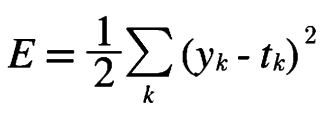

In [ ]:
def sum_squares_error(y, t):
  return 0.5 * np.sum((y - t)**2)

print(sum_squares_error(np.array(y2), np.array(t)))
print(sum_squares_error(np.array(y7), np.array(t)))

0.09750000000000003
0.5975


### Cross entropy error (CEE)

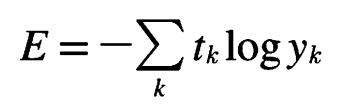

In [ ]:
def cross_entropy_error_prac(y, t):
  delta = 1e-7 # Avoid "log 0 = -inf"
  return -np.sum(t * np.log(y + delta))

print(cross_entropy_error_prac(np.array(y2), np.array(t)))
print(cross_entropy_error_prac(np.array(y7), np.array(t)))

0.510825457099338
2.302584092994546


### Mini-batch training

In [ ]:
(x_train, t_train), (x_test, t_test) = mnist_sk.load_mnist(flatten=True, normalize=False)

print(x_train.shape)
print(t_train.shape)
print("")

train_size = x_train.shape[0]
batch_size = 10
batch_mask = np.random.choice(train_size, batch_size)
x_batch = x_train[batch_mask]
t_batch = t_train[batch_mask]
print(batch_mask)

(60000, 784)
(60000,)

[32451 19421 38632 13487 17834  1879 38920  5564 55177 20902]


* cee_for_batch: (For "decimal" answer label) reshape -> normalize by dividing batch_size -> CEE of one image data
* cee_for_batch_ohe: (For "one-hot encoded" answer label) neglect "zero" component of one-hot encoded "t"

In [ ]:
def cee_for_batch(y, t):
  if y.ndim == 1:
    t = t.reshape(1, t.size)
    y = y.reshape(1, y.size)

  batch_size = y.shape[0]
  return -np.sm(t * np.log(y + 1e-7)) / batch_size

def cee_for_batch_ohe(y, t):
  if y.ndim == 1:
    t = t.reshape(1, t.size)
    y = y.reshape(1, y.size)

  batch_size = y.shape[0]
  return -np.sm(t * np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

### Why "loss function", not "accuracy"?
* NN tries to determine optimal parameters minimizing the loss function.
* However, if accuracy is the metric, optimization cannot be progressed due to "zero gradient"
* Because the accuracy is "discrete", so differentiation cannot be the way to find the better point

## Numerical Differentiation

### Differentiation

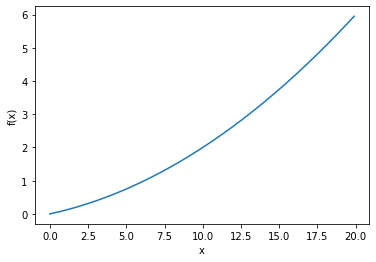

0.1999999999990898
0.2999999999986347


In [ ]:
def numerical_diff(f, x):
  h = 1e-4
  return (f(x+h) - f(x-h)) / (2*h)

def function_1(x):
  return 0.01*x**2 + 0.1*x

x = np.arange(0.0, 20.0, 0.1)
y = function_1(x)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.plot(x, y)
plt.show()

print(numerical_diff(function_1, 5))
print(numerical_diff(function_1, 10))

### Partial differentiation

In [ ]:
def function_2(x):
  return x[0]**2 + x[1]**2 # return np.sum(x**2)도 가능

# x0 = 3, x1 = 4일 때, x0에 대한 편미분 df/dx0를 구하라
def function_tmp1(x0):
  return x0*x0 + 4.0**2.0

def function_tmp2(x1):
  return 3.0**2.0 + x1*x1

print(numerical_diff(function_tmp1, 3.0))
print(numerical_diff(function_tmp2, 4.0))

6.00000000000378
7.999999999999119


### Gradient

In [ ]:
def numerical_gradient(f, x):
  h = 1e-4
  grad = np.zeros_like(x)

  for idx in range(x.size):
    tmp_val = x[idx]
    x[idx] = tmp_val + h
    fxh1 = f(x)
    x[idx] = tmp_val - h
    fxh2 = f(x)
    grad[idx] = (fxh1 - fxh2) / (2*h)
    x[idx] = tmp_val
  
  return grad

print(numerical_gradient(function_2, np.array([3.0, 4.0])))
print(numerical_gradient(function_2, np.array([0.0, 2.0])))
print(numerical_gradient(function_2, np.array([3.0, 0.0])))

[6. 8.]
[0. 4.]
[6. 0.]


### Gradient descent method

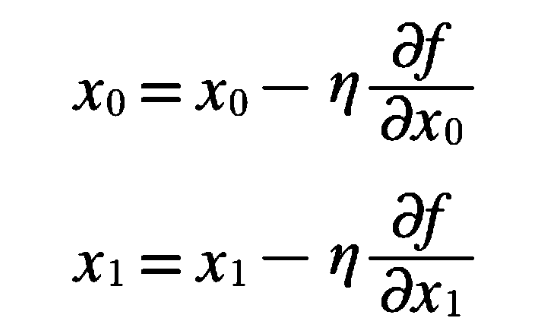

* "eta" is the "learning rate".

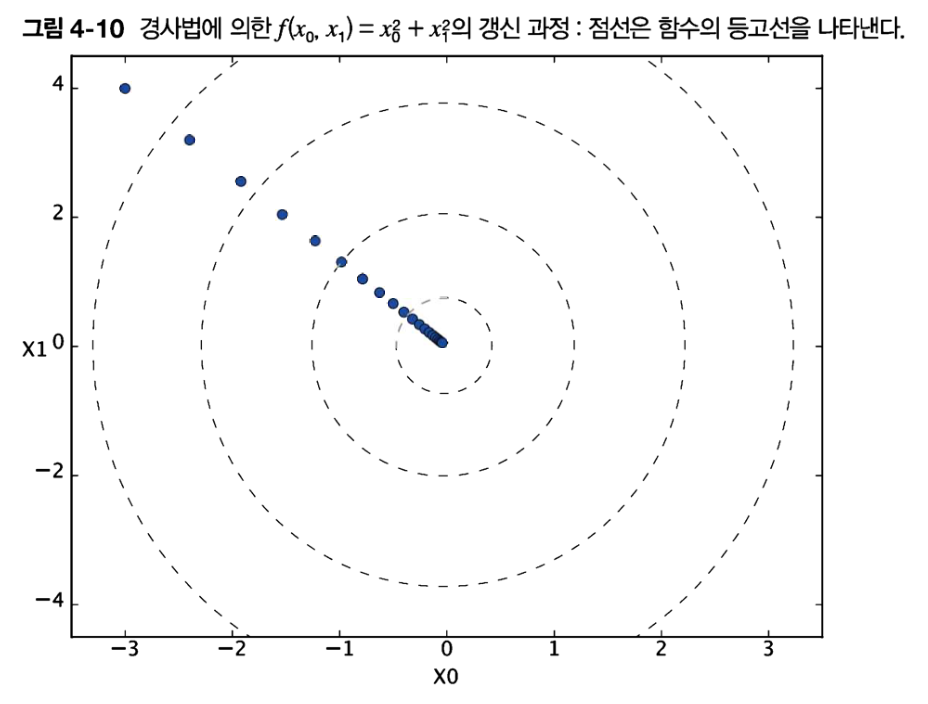

In [ ]:
def gradient_descent(f, init_x, lr = 0.01, step_num=100):
  x = init_x

  for i in range(step_num):
    grad = numerical_gradient(f, x)
    x -= lr * grad

  return x

init_x = np.array([-3.0, 4.0])
print(gradient_descent(function_2, init_x=init_x, lr=0.1, step_num=100))
print("")

# If learning rate is too large: diverge
init_x = np.array([-3.0, 4.0])
print(gradient_descent(function_2, init_x=init_x, lr=10.0, step_num=100))
print("")

# If learning rate is too small: little renewal
init_x = np.array([-3.0, 4.0])
print(gradient_descent(function_2, init_x=init_x, lr=1e-10, step_num=100))

[-6.11110793e-10  8.14814391e-10]

[-2.58983747e+13 -1.29524862e+12]

[-2.99999994  3.99999992]


### Gradient in neural network

In [ ]:
from functions_sk import cross_entropy_error, softmax

class simpleNet:
  def __init__(self):
    self.W = np.random.randn(2, 3)

  def predict(self, x):
    return np.dot(x, self.W)

  def loss(self, x, t):
    z = self.predict(x)
    y = softmax(z)
    loss = cross_entropy_error(y, t)

    return loss

net = simpleNet()
print(net.W)
print("")

x = np.array([0.6, 0.9])
p = net.predict(x)
print(p)
print(np.argmax(p))
print()

t = np.array([0, 0, 1])
print(net.loss(x, t))

[[-0.72945158  0.71413708 -1.40637952]
 [-0.26125294 -0.9091873  -0.53054364]]

[-0.6727986  -0.38978632 -1.32131699]
1

1.6958162343414156


In [ ]:
from gradient_sk import numerical_gradient

def f(W):
  return net.loss(x, t)

dW = numerical_gradient(f, net.W)
print(dW)

[[ 0.21053054  0.2793996  -0.48993013]
 [ 0.31579581  0.41909939 -0.7348952 ]]


## Implementing Learning Algorithms
* Prerequisite
 * In NN, there are adaptive "weights" and "biases", and the process controlling those parameters to adapt to the training data is called "learning".
* First step - Mini batch
 * Select randomly the part of the training data.
 * Those selected data are called "mini batch", and the main purpose is minimizing the loss function value of the mini batch.
* Second step - Gradients calculation
 * Calculate the weight parameters' gradients to minimize the loss function value of the mini batch.
 * Gradients provide the direction for loss minimization.
* Third step - Parameters renewal
 * Slightly renew the weight parameters to the gradients' directions.
* Fourth step - Iteration
 * Iterate from the first to the third step.

### Two-layer neural network class

In [ ]:
from functions_sk import *

class TwoLayerNet:
  # Method "__init__" reset class
  # It is always called when we generate the class
  # Reset the parameters including weights also
  def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
    self.params = {}
    self.params["W1"] = weight_init_std * np.random.randn(input_size, hidden_size)
    self.params["b1"] = np.zeros(hidden_size)
    self.params["W2"] = weight_init_std * np.random.randn(hidden_size, output_size)
    self.params["b2"] = np.zeros(output_size)

  def predict(self, x):
    W1, W2 = self.params["W1"], self.params["W2"]
    b1, b2 = self.params["b1"], self.params["b2"]

    a1 = np.dot(x, W1) + b1
    z1 = sigmoid(a1)
    a2 = np.dot(z1, W2) + b2
    y = softmax(a2)

    return y
  
  def loss(self, x, t):
    y = self.predict(x)
    
    return cross_entropy_error(y, t)

  def accuracy(self, x, t):
    y = self.predict(x)
    y = np.argmax(y, axis=1)
    t = np.argmax(t, axis=1)

    accuracy = np.sum(y == t) / float(x.shape[0])

    return accuracy
  
  def numerical_gradient(self, x, t):
    loss_W = lambda W: self.loss(x, t)

    grads = {}
    grads["W1"] = numerical_gradient(loss_W, self.params["W1"])
    grads["b1"] = numerical_gradient(loss_W, self.params["b1"])
    grads["W2"] = numerical_gradient(loss_W, self.params["W2"])
    grads["b2"] = numerical_gradient(loss_W, self.params["b2"])

    return grads

net = TwoLayerNet(input_size = 784, hidden_size=100, output_size=10)
# Variable "params" saves all the parameters that the NN needs
print(net.params["W1"].shape)
print(net.params["b1"].shape)
print(net.params["W2"].shape)
print(net.params["b2"].shape)

(784, 100)
(100,)
(100, 10)
(10,)


In [ ]:
# Weights saved in "params" are used to predict (forward propagation)
x = np.random.rand(100, 784)
y = net.predict(x)
print(y[:10,:]) # 10 prediction restuls

[[0.10767446 0.10409223 0.10197014 0.09847129 0.09971502 0.09449794
  0.0991675  0.10448953 0.09839176 0.09153014]
 [0.10741929 0.10379661 0.10266309 0.09842297 0.09996297 0.09438986
  0.09887279 0.10441293 0.09857828 0.09148121]
 [0.10737582 0.10386514 0.10193401 0.09835295 0.10010173 0.09451553
  0.09915781 0.10416548 0.09870654 0.09182499]
 [0.10727092 0.10368589 0.10243517 0.09861863 0.09997792 0.09448531
  0.09886579 0.1045476  0.0986063  0.09150648]
 [0.10747932 0.1039407  0.10221603 0.09858774 0.09996704 0.09421558
  0.09885515 0.10446945 0.09855343 0.09171556]
 [0.10732866 0.10388734 0.10230704 0.09847285 0.09976001 0.09446609
  0.09899291 0.10452037 0.09863961 0.09162511]
 [0.10743991 0.10373192 0.1020231  0.09856854 0.09989804 0.09438298
  0.09896035 0.10458984 0.09883419 0.09157113]
 [0.10676173 0.10401555 0.10233325 0.09822948 0.10007522 0.09471495
  0.09901215 0.10468668 0.09855682 0.09161417]
 [0.10759298 0.10390031 0.10217181 0.0987659  0.10014399 0.0942341
  0.09888834 

In [ ]:
# Variable "grads" saves all the gradients corresponding their "params" variables
x = np.random.rand(100, 784)
t = np.random.rand(100, 10)

grads = net.numerical_gradient(x, t) # Time-consuming with Colab server.. about 5 minutes?

print(grads["W1"].shape)
print(grads["b1"].shape)
print(grads["W2"].shape)
print(grads["b2"].shape)

(784, 100)
(100,)
(100, 10)
(10,)


### Implementing mini-batch training

In [8]:
from two_layer_net_sk import TwoLayerNet

(x_train, t_train), (x_test, t_test) = mnist_sk.load_mnist(normalize=True, one_hot_label=True)

train_loss_list = []

# Hyperparameters
iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

for i in range(iters_num):
  # Get mini-batch
  batch_mask = np.random.choice(train_size, batch_size)
  x_batch = x_train[batch_mask]
  t_batch = t_train[batch_mask]

  # Gradient calculation
  grad = network.gradient(x_batch, t_batch) # Function "numerical_gradient" can be used, but is worse than "gradient"

  # Parameters renewal
  for key in ("W1", "b1", "W2", "b2"):
    network.params[key] -= learning_rate * grad[key]

  # Training record
  loss = network.loss(x_batch, t_batch)
  train_loss_list.append(loss)

Text(0, 0.5, 'loss')

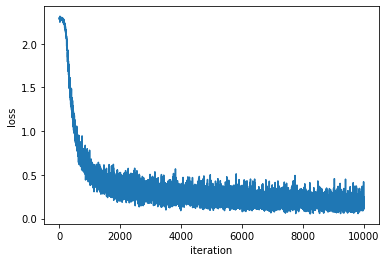

In [9]:
# Loss graph plotting
plt.plot(train_loss_list)
plt.xlabel('iteration')
plt.ylabel('loss')

### Assess training with test data

In [11]:
(x_train, t_train), (x_test, t_test) = mnist_sk.load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

# Hyperparameters
iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = [] # Train set accuracy
test_acc_list = [] # Test set accuracy

# # of the iteration for 1 epoch
iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
  # Get mini-batch
  batch_mask = np.random.choice(train_size, batch_size)
  x_batch = x_train[batch_mask]
  t_batch = t_train[batch_mask]

  # Gradient calculation
  grad = network.gradient(x_batch, t_batch)

  # Parameters renewal
  for key in ("W1", "b1", "W2", "b2"):
    network.params[key] -= learning_rate * grad[key]

  # Training record
  loss = network.loss(x_batch, t_batch)
  train_loss_list.append(loss)

  # Accuracy (per epoch) calculation
  if i % iter_per_epoch == 0:
    train_acc = network.accuracy(x_train, t_train)
    test_acc = network.accuracy(x_test, t_test)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    print("train acc, test acc |" + str(train_acc) + "," + str(test_acc))

train acc, test acc |0.11236666666666667,0.1135
train acc, test acc |0.7822333333333333,0.7879
train acc, test acc |0.8790833333333333,0.8837
train acc, test acc |0.89895,0.9019
train acc, test acc |0.9093833333333333,0.9119
train acc, test acc |0.9151,0.9161
train acc, test acc |0.91945,0.9216
train acc, test acc |0.9243833333333333,0.9258
train acc, test acc |0.9278666666666666,0.9279
train acc, test acc |0.9314166666666667,0.9322
train acc, test acc |0.9338333333333333,0.9344
train acc, test acc |0.9364333333333333,0.9369
train acc, test acc |0.9379333333333333,0.9379
train acc, test acc |0.94,0.9407
train acc, test acc |0.94245,0.9419
train acc, test acc |0.9437666666666666,0.9441
train acc, test acc |0.9464333333333333,0.9445


Text(0, 0.5, 'loss')

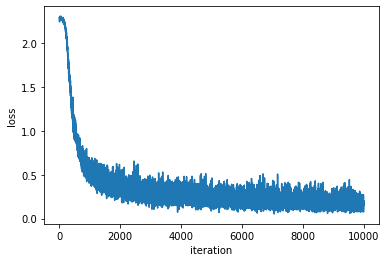

In [12]:
# Loss graph plotting
plt.plot(train_loss_list)
plt.xlabel('iteration')
plt.ylabel('loss')

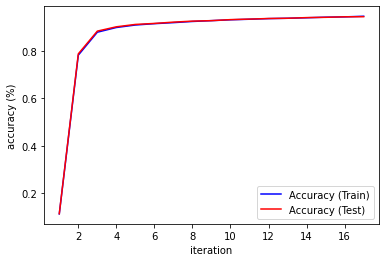

In [31]:
# Accuracy graph (of training set / test set) plotting
tr_len = np.arange(0, len(train_acc_list), 1)
te_len = np.arange(0, len(test_acc_list), 1)
plt.plot(tr_len+1, train_acc_list, "b-", te_len+1, test_acc_list, "r-")
plt.xlabel('iteration')
plt.ylabel('accuracy (%)')
plt.legend(["Accuracy (Train)", "Accuracy (Test)"])

"""
두 정확도 사이 차이가 거의 없으므로 과적합이 발생하지 않았다고 판단할 수 있음
"""